In [1]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np
import pandas as pd
import sqlite3 as sq
import time
import math
import re
from sklearn import preprocessing
import datetime

In [2]:
#just reading data
con = sq.connect("database.sqlite")
team_atts = pd.read_sql_query("SELECT * from Team_Attributes", con)
teams = pd.read_sql_query("SELECT * from Team", con)
matches = pd.read_sql_query("SELECT * from Match", con)
matches = matches[['date', 'season', 'home_team_goal', 'away_team_goal', 'home_team_api_id', 'away_team_api_id', 
                  'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
                  'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD',
                  'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD',
                  'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']]

original_matches = matches.copy()

attr_dates = pd.DataFrame(columns=['date', 'year', 'month'])
attr_dates['date'] = pd.to_datetime(team_atts['date'])
attr_dates['year'] = [attr_date.year for attr_date in attr_dates['date']]
attr_dates['month'] = [attr_date.month for attr_date in attr_dates['date']]

In [3]:
# print(team_atts.columns.values)

### Tasks TODO: 
### Drop columns that are redundant
### Drop rows that are missing too many values
### Replace text data such as "slow, medium, fast" with number mappings that make sense (e.g. 0, 1, 2) 
### Normalize all features to be in the range (0, 1): subtract the low value and divide by (high - low)

buildUpPlaySpeed = {'Slow': 0, 'Balanced': 1, 'Fast': 2}

st = time.time()

denom = len(matches.columns.values)


### Add blank columns for team attributes to be filled in for each match
for column in list(team_atts.columns.values):
    matches['__home_' + column] = np.nan
    
for column in list(team_atts.columns.values):
    matches['__away_' + column] = np.nan

### To assist in filling values later (note the underscores leading __underscoes added above & used here 
### so we don't collide with existing column names)
home_column_indexes = [matches.columns.get_loc('__home_' + col_name) for col_name in team_atts.columns.values]
away_column_indexes = [matches.columns.get_loc('__away_' + col_name) for col_name in team_atts.columns.values]
indexes_to_drop = []

## Part of experiments described below
n_15_none_match = 0
n_15_none_team_att = 0

for index, match in matches.iterrows():
    ### For each match, we find the home and away team for the correct year, and add their data to the 
    ### dataframe
    match_years = [int(year) for year in match['season'].split('/')]
    home_team_id = match['home_team_api_id']
    away_team_id = match['away_team_api_id']
    home_team_atts = team_atts.loc[team_atts['team_api_id'] == home_team_id]
    away_team_atts = team_atts.loc[team_atts['team_api_id'] == away_team_id]
    
    def date_matches(match_years):
        return (((attr_dates['year'] == match_years[0]) & (attr_dates['month'] >= 7)) | 
                ((attr_dates['year'] == match_years[1]) & (attr_dates['month'] < 7)))

    home_team_att = home_team_atts.loc[date_matches(match_years)]
    away_team_att = away_team_atts.loc[date_matches(match_years)]
    
    
    ### This is just an experiment to determine a threshold for how many values should be 'None'
    ### in match data in order for us to drop a row. To drop a row, add its index to "indexes_to_drop"
    ### if too many values are 'None'
    pct_match_none = sum(1 for val in match.values if val is None) / denom
    if pct_match_none > 0.15:
        n_15_none_match += 1

    if not home_team_att.empty and not away_team_att.empty:
        matches.iloc[index, home_column_indexes] = home_team_att.values[0]
        matches.iloc[index, away_column_indexes] = away_team_att.values[0]
        
        
        ### This is just an experiment to determine a threshold for how many values should be 'None'
        ### in team attribute data in order for us to drop a row. To drop a row, add its index to "indexes_to_drop"
        ### if too many values are 'None'
        pct_home_none = sum(1 for val in home_team_att.values[0] if val is None) / len(home_team_att.values)
        pct_away_none = sum(1 for val in away_team_att.values[0] if val is None) / len(away_team_att.values)
        if pct_home_none > 0.15 or pct_away_none > 0.3:
            n_15_none_team_att += 1
        
    else:
        indexes_to_drop.append(index)

### Part of our experiments
n_rows = index
print('total input rows:', n_rows)
print('num lacking any team attribute data:', len(indexes_to_drop))
print('num where >15% of team data is None:', n_15_none_match)
print('num where >15% of team attribute data is None:', n_15_none_team_att)

matches = matches.drop(indexes_to_drop, axis=0) ### Drops rows that lack too much data

print('Took {0:.2f} seconds.'.format(time.time() - st))

total input rows: 25978
num lacking any team attribute data: 7785
num where >15% of team data is None: 11762
num where >15% of team attribute data is None: 0
Took 418.94 seconds.


In [4]:
print(matches.columns.values, len(matches.columns.values))

#drop first 13 of matches:
matches = matches.drop(['date', 'season', 'home_team_goal', 'away_team_goal' ,'home_team_api_id',
 'away_team_api_id', 'goal', 'shoton' ,'shotoff', 'foulcommit', 'card', 'cross',
 'corner', 'possession'], axis=1)


['date' 'season' 'home_team_goal' 'away_team_goal' 'home_team_api_id'
 'away_team_api_id' 'goal' 'shoton' 'shotoff' 'foulcommit' 'card' 'cross'
 'corner' 'possession' 'B365H' 'B365D' 'B365A' 'BWH' 'BWD' 'BWA' 'IWH'
 'IWD' 'IWA' 'LBH' 'LBD' 'LBA' 'PSH' 'PSD' 'PSA' 'WHH' 'WHD' 'WHA' 'SJH'
 'SJD' 'SJA' 'VCH' 'VCD' 'VCA' 'GBH' 'GBD' 'GBA' 'BSH' 'BSD' 'BSA'
 '__home_id' '__home_team_fifa_api_id' '__home_team_api_id' '__home_date'
 '__home_buildUpPlaySpeed' '__home_buildUpPlaySpeedClass'
 '__home_buildUpPlayDribbling' '__home_buildUpPlayDribblingClass'
 '__home_buildUpPlayPassing' '__home_buildUpPlayPassingClass'
 '__home_buildUpPlayPositioningClass' '__home_chanceCreationPassing'
 '__home_chanceCreationPassingClass' '__home_chanceCreationCrossing'
 '__home_chanceCreationCrossingClass' '__home_chanceCreationShooting'
 '__home_chanceCreationShootingClass'
 '__home_chanceCreationPositioningClass' '__home_defencePressure'
 '__home_defencePressureClass' '__home_defenceAggression'
 '__home_defenc

In [5]:
print(matches.columns.values, len(matches.columns.values))

['B365H' 'B365D' 'B365A' 'BWH' 'BWD' 'BWA' 'IWH' 'IWD' 'IWA' 'LBH' 'LBD'
 'LBA' 'PSH' 'PSD' 'PSA' 'WHH' 'WHD' 'WHA' 'SJH' 'SJD' 'SJA' 'VCH' 'VCD'
 'VCA' 'GBH' 'GBD' 'GBA' 'BSH' 'BSD' 'BSA' '__home_id'
 '__home_team_fifa_api_id' '__home_team_api_id' '__home_date'
 '__home_buildUpPlaySpeed' '__home_buildUpPlaySpeedClass'
 '__home_buildUpPlayDribbling' '__home_buildUpPlayDribblingClass'
 '__home_buildUpPlayPassing' '__home_buildUpPlayPassingClass'
 '__home_buildUpPlayPositioningClass' '__home_chanceCreationPassing'
 '__home_chanceCreationPassingClass' '__home_chanceCreationCrossing'
 '__home_chanceCreationCrossingClass' '__home_chanceCreationShooting'
 '__home_chanceCreationShootingClass'
 '__home_chanceCreationPositioningClass' '__home_defencePressure'
 '__home_defencePressureClass' '__home_defenceAggression'
 '__home_defenceAggressionClass' '__home_defenceTeamWidth'
 '__home_defenceTeamWidthClass' '__home_defenceDefenderLineClass'
 '__away_id' '__away_team_fifa_api_id' '__away_team_api_

In [6]:
#Enumerate the columns if they have string values
newCol = {}
for col in matches.columns.values:
    if re.search('Class', col):
            #print(col, matches[col])
            #enum_dict = dict(enumerate(list(set(matches[col]))))
            enum_dict = { k: v for v, k in dict(enumerate(list(set(matches[col])))).items()}
            #print(col, enum_dict)
            #print(matches[col])
            newCol[col] = matches[col].map(enum_dict)
#print(newCol['__home_buildUpPlaySpeedClass'])
for colName in newCol.keys():
    matches[colName] = newCol[colName]

In [7]:
# __home_buildUpPlaySpeedClass {'Balanced': 0, 'Slow': 1, 'Fast': 2}
# __home_buildUpPlayDribblingClass {'Normal': 0, 'Little': 1, 'Lots': 2}
# __home_buildUpPlayPassingClass {'Mixed': 0, 'Long': 1, 'Short': 2}
# __home_buildUpPlayPositioningClass {'Organised': 0, 'Free Form': 1}
# __home_chanceCreationPassingClass {'Risky': 0, 'Normal': 1, 'Safe': 2}
# __home_chanceCreationCrossingClass {'Normal': 0, 'Little': 1, 'Lots': 2}
# __home_chanceCreationShootingClass {'Normal': 0, 'Little': 1, 'Lots': 2}
# __home_chanceCreationPositioningClass {'Organised': 0, 'Free Form': 1}
# __home_defencePressureClass {'Deep': 0, 'Medium': 1, 'High': 2}
# __home_defenceAggressionClass {'Double': 0, 'Contain': 1, 'Press': 2}
# __home_defenceTeamWidthClass {'Normal': 0, 'Wide': 1, 'Narrow': 2}
# __home_defenceDefenderLineClass {'Offside Trap': 0, 'Cover': 1}
# __away_buildUpPlaySpeedClass {'Balanced': 0, 'Slow': 1, 'Fast': 2}
# __away_buildUpPlayDribblingClass {'Normal': 0, 'Little': 1, 'Lots': 2}
# __away_buildUpPlayPassingClass {'Mixed': 0, 'Long': 1, 'Short': 2}
# __away_buildUpPlayPositioningClass {'Organised': 0, 'Free Form': 1}
# __away_chanceCreationPassingClass {'Normal': 0, 'Risky': 1, 'Safe': 2}
# __away_chanceCreationCrossingClass {'Normal': 0, 'Little': 1, 'Lots': 2}
# __away_chanceCreationShootingClass {'Normal': 0, 'Little': 1, 'Lots': 2}
# __away_chanceCreationPositioningClass {'Organised': 0, 'Free Form': 1}
# __away_defencePressureClass {'Deep': 0, 'Medium': 1, 'High': 2}
# __away_defenceAggressionClass {'Double': 0, 'Contain': 1, 'Press': 2}
# __away_defenceTeamWidthClass {'Normal': 0, 'Wide': 1, 'Narrow': 2}
# __away_defenceDefenderLineClass {'Offside Trap': 0, 'Cover': 1}

In [8]:
# Get rid of cols missing betting odds
to_remove = []
columns = matches.columns.values[:30]
for index, match in matches.iterrows():
    n_missing = 0
    for col in columns: 
        if pd.isnull(match[col]):
            n_missing += 1
    if n_missing >= 15:
        to_remove.append(index)
        
matches = matches.drop(to_remove, axis=0)
matches = matches.drop(['__home_id', '__home_team_api_id', '__away_id', '__away_team_api_id'], axis=1)

In [9]:
new_to_remove = []
for col in matches.columns.values:
    if re.search('date', col):
        new_to_remove.append(col)
matches = matches.drop(new_to_remove, axis=1)
print(matches.columns.values)

['B365H' 'B365D' 'B365A' 'BWH' 'BWD' 'BWA' 'IWH' 'IWD' 'IWA' 'LBH' 'LBD'
 'LBA' 'PSH' 'PSD' 'PSA' 'WHH' 'WHD' 'WHA' 'SJH' 'SJD' 'SJA' 'VCH' 'VCD'
 'VCA' 'GBH' 'GBD' 'GBA' 'BSH' 'BSD' 'BSA' '__home_team_fifa_api_id'
 '__home_buildUpPlaySpeed' '__home_buildUpPlaySpeedClass'
 '__home_buildUpPlayDribbling' '__home_buildUpPlayDribblingClass'
 '__home_buildUpPlayPassing' '__home_buildUpPlayPassingClass'
 '__home_buildUpPlayPositioningClass' '__home_chanceCreationPassing'
 '__home_chanceCreationPassingClass' '__home_chanceCreationCrossing'
 '__home_chanceCreationCrossingClass' '__home_chanceCreationShooting'
 '__home_chanceCreationShootingClass'
 '__home_chanceCreationPositioningClass' '__home_defencePressure'
 '__home_defencePressureClass' '__home_defenceAggression'
 '__home_defenceAggressionClass' '__home_defenceTeamWidth'
 '__home_defenceTeamWidthClass' '__home_defenceDefenderLineClass'
 '__away_team_fifa_api_id' '__away_buildUpPlaySpeed'
 '__away_buildUpPlaySpeedClass' '__away_buildUpPlay

In [23]:
filtered_og_matches = original_matches.copy()
filtered_og_matches = filtered_og_matches.loc[matches.index.values]

n_home_wins = len(filtered_og_matches[filtered_og_matches['home_team_goal'] > filtered_og_matches['away_team_goal']])
n_draws = len(filtered_og_matches[filtered_og_matches['home_team_goal'] == filtered_og_matches['away_team_goal']])
n_away_wins = len(filtered_og_matches[filtered_og_matches['home_team_goal'] < filtered_og_matches['away_team_goal']])
n_games = len(filtered_og_matches)

assert(n_games == n_home_wins + n_draws + n_away_wins)

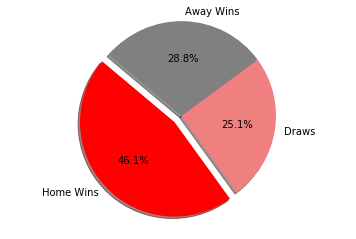

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
 
# Data to plot
labels = 'Home Wins', 'Draws', 'Away Wins'
sizes = [n_home_wins, n_draws, n_away_wins]
colors = ['red', 'lightcoral', 'grey']
explode = (0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.savefig('games_pie_chart.png')
plt.show()

In [12]:
#fill in missing data with na with -1
#CHANGE LATER TO BE MORE ROBUST
matches = matches.fillna(-1)
matches.to_csv('most_seasons_unnormalized.csv', index=False)
matches

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,...,__away_chanceCreationShooting,__away_chanceCreationShootingClass,__away_chanceCreationPositioningClass,__away_defencePressure,__away_defencePressureClass,__away_defenceAggression,__away_defenceAggressionClass,__away_defenceTeamWidth,__away_defenceTeamWidthClass,__away_defenceDefenderLineClass
306,1.22,6.00,13.00,1.20,5.50,10.50,1.20,5.00,10.00,1.17,...,50.0,1,1,50.0,0,50.0,0,50.0,1,1
307,2.50,3.25,2.60,2.60,3.30,2.40,2.60,3.10,2.30,2.40,...,45.0,1,1,60.0,0,70.0,2,70.0,0,1
308,2.88,3.30,2.25,2.75,3.30,2.25,2.40,3.10,2.50,2.70,...,60.0,1,1,45.0,0,50.0,0,40.0,1,1
309,2.30,3.30,2.88,2.05,3.25,3.15,2.00,3.20,3.10,2.20,...,50.0,1,1,70.0,2,60.0,0,70.0,0,1
310,5.75,3.60,1.57,5.50,3.50,1.55,5.00,3.70,1.50,5.50,...,60.0,1,1,70.0,2,50.0,0,70.0,0,1
311,2.30,3.30,2.80,2.30,3.25,2.70,2.20,3.10,2.80,2.25,...,55.0,1,1,70.0,2,70.0,2,70.0,0,1
312,2.90,3.30,2.25,2.55,3.30,2.45,2.30,3.10,2.60,2.60,...,50.0,1,1,70.0,2,70.0,2,70.0,0,1
313,2.50,3.25,2.60,2.45,3.15,2.65,2.30,3.10,2.60,2.40,...,60.0,1,1,70.0,2,50.0,0,70.0,0,1
314,1.50,3.75,6.50,1.50,3.65,6.30,1.45,3.80,5.40,1.50,...,60.0,1,1,70.0,2,65.0,0,70.0,0,1
315,2.50,3.40,2.70,2.30,3.15,2.80,2.30,3.10,2.60,2.25,...,50.0,1,1,70.0,2,60.0,0,70.0,0,1


In [13]:
#get labels
new_to_remove = []
og = pd.read_sql_query("SELECT * from Match", con)
index = range(0,og.shape[0]) # number rows
columns = ['Home', 'Draw', 'Away']
labels =  pd.DataFrame(index=index, columns=columns)
print(index, matches.index.values)
for index, match in og.iterrows():
    if index in matches.index.values:
        if match['home_team_goal'] > match['away_team_goal']:
            labels.at[index, 'Home'] = 1
        elif match['home_team_goal'] == match['away_team_goal']:
            labels.at[index, 'Draw'] = 1
        else:
            labels.at[index, 'Away'] = 1
    else:
        new_to_remove.append(index)
        
labels = labels.drop(new_to_remove, axis=0)
labels = labels.fillna(0)
assert(labels.index.values.all() == matches.index.values.all())
labels.to_csv('labels_most_seasons.csv', index=False)

range(0, 25979) [  306   307   308 ... 24554 24555 24556]


In [ ]:
#shuffle match rows so split tables are randomized
# matches = matches.reindex(np.random.permutation(matches.index))

# matches.to_csv('cleaned_data.csv')
#split match data into training, validation, and test sets
# m_train = matches.iloc[:17861]
# m_valid = matches.iloc[17861:21108]
# m_test = matches.iloc[21108:]